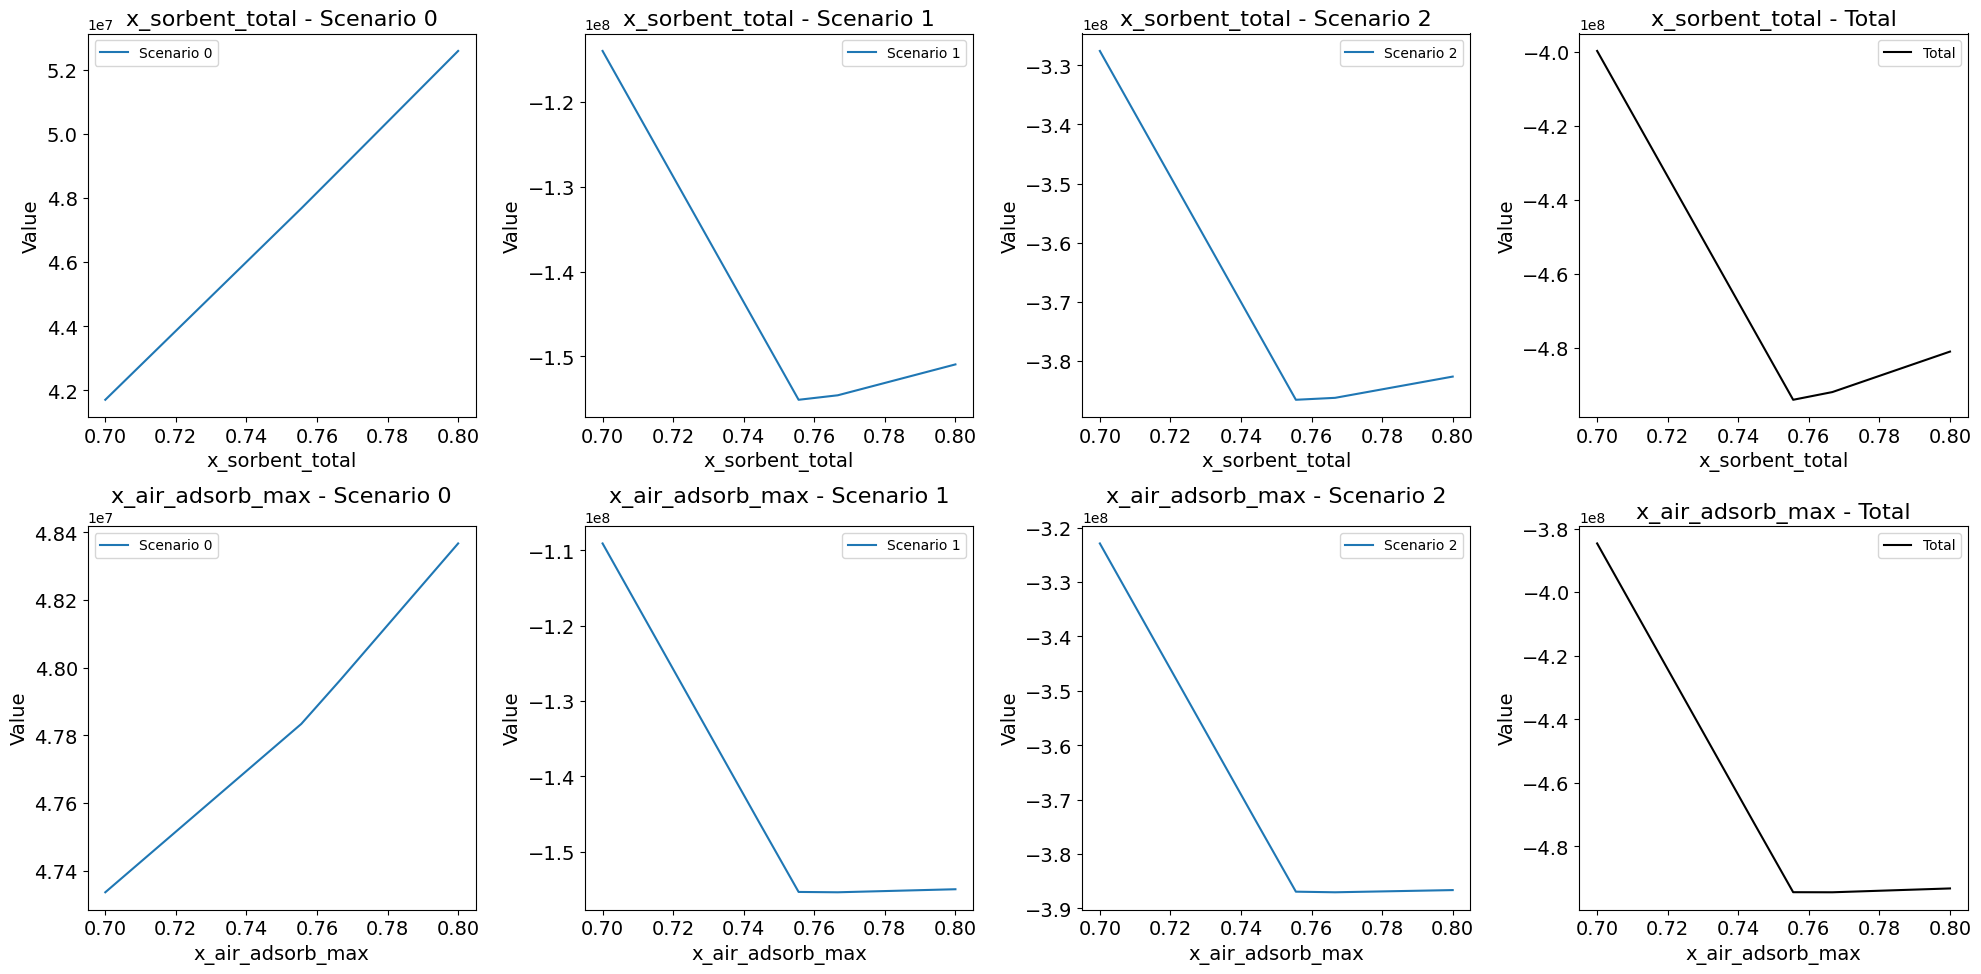

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyomo.opt import SolverFactory, TerminationCondition
from src.analyses.value_function import ValueFunction
from src.analyses.convergence_analysis import HausdorffAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from scipy.optimize import curve_fit
from NSPLIB.src.instances.FLECCS.src.pyomo_model.model import const_model
import copy
fleccs_obj = -4.946928843629e+08  # Replace with actual value
fleccs_sol = {'x_sorbent_total': 0.7571021770410511,'x_air_adsorb_max': 0.7567643358197031} 
fleccs_y_bound = {'x_sorbent_total': [0.7, 0.8],"x_air_adsorb_max": [0.7, 0.8]}

n_day = 7
week_diff = 52
sto_m = const_model(n_day=n_day, week_diff=week_diff)
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()
y_dimension = {
    'x_sorbent_total': {},
    'x_air_adsorb_max': {}
}

steps=10
v_f = ValueFunction(m, solver="gurobi")
for y in y_dimension.keys():
    v_f.calc_1D(idx=y, y_val_fix=copy.deepcopy(fleccs_sol),
                    interval=fleccs_y_bound[y], step=steps)
    for s in m.scenarios:
        y_dimension[y][s] = v_f.value_func[s]
    y_dimension[y]['total'] = v_f.total_value_func

fig, axs = plt.subplots(
    nrows=len(y_dimension), 
    ncols=len(m.scenarios) + 1, 
    figsize=(5 * (len(m.scenarios) + 1), 5 * len(y_dimension))
)
for row_idx, (y_key, y_data) in enumerate(y_dimension.items()):
    for col_idx, s in enumerate(m.scenarios):
        ax = axs[row_idx, col_idx] if len(y_dimension) > 1 else axs[col_idx]
        ax.plot(
            np.linspace(*fleccs_y_bound[y_key], steps), 
            y_data[s], 
            label=f"Scenario {s}"
        )
        ax.set_title(f"{y_key} - Scenario {s}", fontsize=16)
        ax.set_xlabel(y_key, fontsize=14)
        ax.set_ylabel("Value", fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        ax.legend()
    # Plot total in the last column
    ax = axs[row_idx, -1] if len(y_dimension) > 1 else axs[-1]
    ax.plot(
        np.linspace(*fleccs_y_bound[y_key], steps), 
        y_data['total'], 
        label="Total", color='black'
    )
    ax.set_title(f"{y_key} - Total", fontsize=16)
    ax.set_xlabel(y_key, fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend()

plt.tight_layout()
plt.show()